### **User Clarification and Brief Generation**

*The goal of scoping is to gather user-context needed for research.*

The research is scopped in two phases:
- **User Clarifiction** - Determines if additional clarification is needed from the user
- **Brief Generation** - Transform the conversation into a detailed research brief

#### **State and Schemas**

First, we'll define the state object and schemas for our process.

The state object serves as our primary mechanism for storing and passing context between different phrases of the research workflow.

We can use it to write and select context that will be used to guide the research.

In [1]:
%%writefile ../src/states/state_scope.py

"""
State Definitions and Pydantic Schemas for Research Scoping

This defines the state objects and structured schemas used for
the research agent scoping workflow, includin researcher state management and output schemas.
"""

import operator
from typing_extensions import Optional, Annotated, List, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

# State Definitions

class AgentInputState(MessagesState):
    """Input state for the full agent - only contains messages from user input."""
    pass

class AgentState(MessagesState):
    """
    Main state for the full multi-agent research system.

    Extends MessagesStates with additional fields for research coordination.
    Note: Some fields are duplicated across different state classes for proper
    state managment between subgraphs and the main workflow.
    """

    # Research brief generated from user conversation history
    research_brief: Optional[str]
    # Messages exchanged with the supervisor agent for coordination
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # Raw unprocessed research notes collected during the research phase
    raw_notes: Annotated[list[str], operator.add] = []
    # Processed and strctured notes ready for report generation
    notes: Annotated[list[str], operator.add] = []
    # Final formatted research report
    final_report: str

# Structured Output Schemas

class ClarifyWithUser(BaseModel):
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope.",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )


Overwriting ../src/states/state_scope.py


#### **Scope Research**

Now, we'll create a simple workflow to clarify user's intent and write a research brief.

We'll let the LLM determine whether it has sufficient clarification to write the brief.

This will use LangGraph's Command to direct the control flow and updating state. The `Command` object takes two key parameters:
- `goto`: Specifies the next node to execute (or `END` to terminate)
- `update`: Dictionary of states updates to apply before transitioning

This pattern allows our functions to both process data and direct the workflow based on their results.

It creates a more flexible and maintainable system than traditional static graph structures.

In [2]:
%%writefile ../src/research_agent_scope.py

"""
User clarification and Research Brief Generation

This module implements the scoping phase of the research workflow, where we:
1. Assess if the user's requests needs clarification
2. Generate a detailed research brief from the conversation

The workflow uses structured output to make deterministic decisions abou
whether sufficient context existis to proceed with research.
"""

from datetime import datetime
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from prompts import clarify_with_user_instructions, transform_messages_into_research_topic_prompt
from states.state_scope import AgentState, ClarifyWithUser, ResearchQuestion, AgentInputState

from langchain_core.rate_limiters import InMemoryRateLimiter

import os
os.chdir(os.path.dirname(os.path.realpath(__file__)))

# == Utility Functions ==
def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")


# == Configuration ==

# Initialize model
rate_limiter = InMemoryRateLimiter(
    requests_per_second=8.3,
    check_every_n_seconds=0.1,
    #max_bucket_size=10
)
model = init_chat_model(model="openai:gpt-4.1", temperature=0.0, rate_limiter=rate_limiter)

# Nodes
def clarify_with_user(state: AgentState) -> Command[Literal["write_research_brief", "__end__"]]:
    """
    Clarification decision node.

    Determines if the user's request contains sufficient information to proceed
    with research or if additional clarification is need.

    Uses structured output to make deterministic decisions and avoid hallucination.
    Routes to either research brief generation of ends with a clarification question.
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(ClarifyWithUser)

    # Invoke the model with clarification instructions
    response = structured_output_model.invoke([
        HumanMessage(content=clarify_with_user_instructions.format(
            messages=get_buffer_string(messages=state["messages"]),
            date=get_today_str()
        ))
    ])

    # Route based on clarification need
    if response.need_clarification:
        return Command(
            goto=END,
            update={"messages": [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto="write_research_brief",
            update={"messages": [AIMessage(content=response.verification)]}
        )


def write_research_brief(state: AgentState):
    """
    Research brief generation node.

    Transforms the conversation history into a detailed research brief
    that will guide the subsequent research phase.

    Uses structured output to ensure the brief follow the required format
    and contains all necessary details for effective research.
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(ResearchQuestion)

    # Generate research brief from conversation history
    response = structured_output_model.invoke([
        HumanMessage(content=transform_messages_into_research_topic_prompt.format(
            messages=get_buffer_string(messages=state["messages"]),
            date=get_today_str()
        ))
    ])

    # Update state with generated research brief and pass it to the supervisor
    return {
        "research_brief": response.research_brief,
        "supervisor_messages": [HumanMessage(content=f"{response.research_brief}.")]
    }

# == Graph Construcion ==

# Building the scoping workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)

# Add edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", END)

# Compile the workflow
scope_research = deep_researcher_builder.compile()


Overwriting ../src/research_agent_scope.py


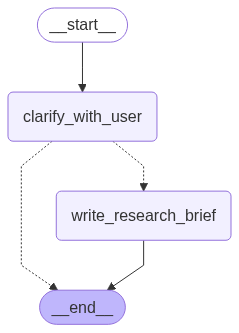

In [3]:
# Compile with in-memory checkpointer to test in notebook
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
import sys
sys.path.append("../src/")
from research_agent_scope import deep_researcher_builder

checkpointer = InMemorySaver()
scope = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph().draw_mermaid_png()))

In [4]:
# Run the full workflow
from utils import format_messages
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "1"}}
result = scope.invoke({"messages": [HumanMessage(
    content="I want to research the best coffe shops in San Francisco."
)]}, config=thread)

format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffe shops in San Francisco.                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you please specify what criteria are most important to you when determining the 'best' coffee shops? For  │
│ example, are you interested in ambiance, specialty coffee, food options, Wi-Fi availability, or something else? │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [5]:
result = scope.invoke({"messages": [HumanMessage(
    content="Let's examine coffee quality to asses the best coffee shops in San Francisco."
)]}, config=thread)

format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffe shops in San Francisco.                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you please specify what criteria are most important to you when determining the 'best' coffee shops? For  │
│ example, are you interested in ambiance, specialty coffee, food options, Wi-Fi availability, or something else? │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's examine coffee quality to asses the best coffee shops in San Francisco.                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for clarifying that you would like to focus on coffee quality when assessing the best coffee shops in │
│ San Francisco. I now have sufficient information to proceed and will begin researching top coffee shops in San  │
│ Francisco based on their coffee quality.                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [6]:
from rich.markdown import Markdown
Markdown(result['research_brief'])

I want to identify the best coffee shops in San Francisco, focusing specifically on coffee quality as the primary  
criterion. In my research, I would like to consider factors that contribute to coffee quality, such as bean        
sourcing, roasting methods, brewing techniques, and taste. Other aspects like ambiance, food options, Wi-Fi        
availability, or price are not specified as important for this research and can be treated as flexible or open     
considerations. Please prioritize information from official coffee shop websites, reputable specialty coffee       
publications, and user reviews from primary platforms (such as Google Reviews or Yelp) that specifically address   
coffee quality.

### **Evaluation**

Now that we've scoped our research, let's test it with a few examples to make sure that it's working as expected.

Let's think about what makes for a good research brief:

- It captures relevant criteria from the user chat
- It does not invent of assume any criteria that the user did not explicitly provide

Here are two sample input conversations.

In [7]:
from langchain_core.messages import AIMessage

conversation_1 = [
    HumanMessage(content="What's the best way to invest $50,000 for retirement?"),
    AIMessage(content="Could you please provide some additional information to tailor the investment advice for your $50,000 retirement goal? Specifically:\n Your current age or desired retirement age\n Your risk tolerance (low, medium, high)\n Any preferences for investment types (e.g., stocks, bonds, mutual funds, real estate)\n Whether you are investing through a tax-advantaged account (e.g., IRA, 401(k)) or a regular brokerage account\n This will help me provide more personalized and relevant suggestions."),
    HumanMessage(content="I'm 25 and I want to retire by 45. My risk tolerance is high right now but I think will decrease over time. I have heard that stocks and ETFs are a good choice, but I'm open to anything. And I already have a 401k, but this would just be through a regular brokerage account."),
]

conversation_2 = [
    HumanMessage(content="I am looking for an apartment in NYC, can you help me?"),
    AIMessage(content="Could you please specify your apartment preferences? For example:\n Desired neighborhoods or boroughs\n Number of bedrooms/bathrooms\n Budget range (monthly rent)\n Any amenities or must-have features\n Preferred move-in date\n This information will help me provide the most relevant apartment options in NYC."),
    HumanMessage(content="I'd prefer to live in Chelsea, Flatiron, or West Village. I'm looking for a 2 bed 2 bath, and I am looking for monthly rent below 7k. I'd like this to be a doorman building and have an in unit washer and dryer, but it's okay if there's no washer dryer. It's a plus if the building has a gym. And I'd like to move in in September 2025."),
]

Now let's manually write out each criteria from these conversations that we would want preserved by a research brief.

In [8]:
criteria_1 = [
    "Current age is 25",
    "Desired retirement age is 45",
    "Current risk tolerance is high",
    "Interested in investing in stocks and ETFs",
    "Open to forms of investment beyond stocks and ETFs"
    "Investment account is a regular brokerage account",
]

criteria_2 = [
    "Looking for a 2 bed 2 bath apartment in Chelsea, Flatiron, or West Village",
    "Monthly rent below 7k",
    "Should be in a doorman building",
    "Ideally have an in unit washer and dryer but not strict",
    "Ideally have a gym but not strict",
    "Move in date is September 2025"
]

We're going to use LangSmith to run this experiment.

Running an experiment in LangSmith comprises of three steps:
1. Creating the dataset
2. Writing the evaluator(s)
3. Running the experiment

In [9]:
import os
from langsmith import Client

# Initialize the LangSmith client
langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# Create the dataset
dataset_name = "deep_research_scoping"
if not langsmith_client.has_dataset(dataset_name=dataset_name):

    # Create the dataset
    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that measures the quality of research briefs generated from an input conversation",
    )

    # Add the examples to the dataset
    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"messages": conversation_1},
                "outputs": {"criteria": criteria_1},
            },
            {
                "inputs": {"messages": conversation_2},
                "outputs": {"criteria": criteria_2},
            },
        ],
    )

Now, we need to write an evaluator that will compare our research brief against the success criteria that we have specified for each example. For this, we'll use an LLM-as-judge. You can fine some useful tips for writing llm-as-judge evaluators here, which include:

1. **Role Definition with Expertise Context**

- Defined specific expert roles ("research brief evaluator", "meticulous auditor")
- Specialized the role to the specific evaluation domain

2. **Clear Task Specification**

- Binary pass/fail judgments (avoiding complex multi-dimensional scoring)
- Explicit task boundaries and objectives
- Focus on actionable evaluation criteria

3. **Rich Contextual Background**

- Provide domain-specific context about research brief quality
- Explain the importance of accurate evaluation
- Connect evaluation outcomes to downstream consequences

4. **Structured XML Organization**

- Used semantic XML tags for different sections
- Clear separation of role, task, context, inputs, guidelines, and outputs
- Improved prompt parsing and comprehension

5. **Comprehensive Guidelines with Examples**

- Detailed PASS/FAIL criteria with specific conditions
- Multiple concrete examples showing correct judgments
- 3-4 examples per prompt covering different scenarios
- Both positive and negative examples for each judgment type
- Edge case handling and decision boundary clarification

6. **Explicit Output Instructions**

- Clear guidance on how to apply the evaluation criteria
- Instructions for handling ambiguous cases
- Emphasis on consistency and systematic evaluation

7. **Bias Reduction Techniques**

- "Strict but fair" guidance to balance precision and recall
- "When in doubt, lean toward FAIL" for conservative evaluation
- Systematic evaluation process to reduce subjective variation

In [10]:
from prompts import BRIEF_CRITERIA_PROMPT
from typing_extensions import cast
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

class Criteria(BaseModel):
    """
    Individual success criteria evaluation result.

    This model represents a single evaluation criteria that should be present
    in the research brief, along with a detailed assessment of whether it was
    successfully captured and the reasoning behind that assessment.
    """
    criteria_text: str = Field(
        description="The specific success criteria being evaluated (e.g., 'Current age is 25', 'Monthly rent below 7k')"
    )
    reasoning: str = Field(
        description="Detailed explanation of why this criteria is or isn't captured in the research brief, including specific evidence from the brief"
    )
    is_captured: bool = Field(
        description="Whether this specific criteria is adequately captured in the research brief (True) or missing/inadequately addressed (False)"
    )

def evaluate_success_criteria(outputs: dict, reference_outputs: dict):
    """
    Evaluate whether the research brief captures all required success criteria.

    This function evaluates each criterion individually to provide focused assessment
    and detailed reasoning for each evaluation decision.

    Args:
        outputs: Dictionary containing the research brief to evaluate
        reference_outputs: Dictionary containing the list of success criteria

    Returns:
        Dict with evaluation results including score (0.0 to 1.0)
    """
    research_brief = outputs["research_brief"]
    success_criteria = reference_outputs["criteria"]

    model = ChatOpenAI(model="gpt-4.1", temperature=0)
    structured_output_model = model.with_structured_output(Criteria)

    # Run evals
    responses = structured_output_model.batch([
    [
        HumanMessage(
            content=BRIEF_CRITERIA_PROMPT.format(
                research_brief=research_brief,
                criterion=criterion
            )
        )
    ] 
    for criterion in success_criteria])
    
    # Ensure the criteria_text field is populated correctly
    individual_evaluations = [
        Criteria(
            reasoning=response.reasoning,
            criteria_text=criterion,
            is_captured=response.is_captured
        )
        for criterion, response in zip(success_criteria, responses)
    ]
    
    # Calculate overall score as percentage of captured criteria
    captured_count = sum(1 for eval_result in individual_evaluations if eval_result.is_captured)
    total_count = len(individual_evaluations)
    
    return {
        "key": "success_criteria_score", 
        "score": captured_count / total_count if total_count > 0 else 0.0,
        "individual_evaluations": [
            {
                "criteria": eval_result.criteria_text,
                "captured": eval_result.is_captured,
                "reasoning": eval_result.reasoning
            }
            for eval_result in individual_evaluations
        ]
    }

Our second evaluator will check that the research brief does not make any assumptions that the user did not specify in the research brief.

In [11]:
from prompts import BRIEF_HALLUCINATION_PROMPT

# Improved NoAssumptions class with reasoning field and enhanced descriptions
class NoAssumptions(BaseModel):
    """
    Evaluation model for checking if research brief makes unwarranted assumptions.

    This model evaluates whether the research brief contains any assumptions,
    inferences, or additions that were not explicitly stated by the user in their
    original conversation. It provides detailed reasoning for the evaluation decision.
    """
    no_assumptions: bool = Field(
        description="Whether the research brief avoids making unwarranted assumptions. True if the brief only includes information explicitly provided by the user, False if it makes assumptions beyond what was stated."
    )
    reasoning: str = Field(
        description="Detailed explanation of the evaluation decision, including specific examples of any assumptions found or confirmation that no assumptions were made beyond the user's explicit statements."
    )

def evaluate_no_assumptions(outputs: dict, reference_outputs: dict):
    """
    Evaluate whether the research brief avoids making unwarranted assumptions.

    This evaluator checks that the research brief only includes information
    and requirements that were explicitly provided by the user, without
    making assumptions about unstated preferences or requirements.

    Args:
        outputs: Dictionary containing the research brief to evaluate
        reference_outputs: Dictionary containing the success criteria for reference

    Returns:
        Dict with evaluation results including boolean score and detailed reasoning
    """
    research_brief = outputs["research_brief"]
    success_criteria = reference_outputs["criteria"]

    model = ChatOpenAI(model="gpt-4.1", temperature=0)
    structured_output_model = model.with_structured_output(NoAssumptions)

    response = structured_output_model.invoke([
        HumanMessage(content=BRIEF_HALLUCINATION_PROMPT.format(
            research_brief=research_brief,
            success_criteria=str(success_criteria)
        ))
    ])

    return {
        "key": "no_assumptions_score",
        "score": response.no_assumptions,
        "reasoning": response.reasoning
    }

Now that we have our evaluators, we can run our experiment.

In [12]:
import uuid

def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    return scope.invoke(inputs, config=config)

langsmith_client.evaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_success_criteria, evaluate_no_assumptions],
    experiment_prefix="Deep Research Scoping",
)

/home/lucasraniere/git/langgraph-project-deep-research/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


View the evaluation results for experiment: 'Deep Research Scoping-edadbddf' at:
https://smith.langchain.com/o/29030f9f-1b1f-45f1-b0d1-be78131813d8/datasets/30bc97b3-5468-4444-aeff-a414f0a05102/compare?selectedSessions=f2e4474e-4d99-4467-b104-ec6dff0e806e




0it [00:00, ?it/s]Error running evaluator <DynamicRunEvaluator evaluate_success_criteria> on run e467b425-7a8f-4961-8d24-48d8b8394b46: RateLimitError("Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-sdEW2ZAmSKu98CPwO1IA8h8q on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}")
Traceback (most recent call last):
  File "/home/lucasraniere/git/langgraph-project-deep-research/.venv/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1620, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(  # type: ignore[call-arg]
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lucasraniere/git/langgrap

<ExperimentResults Deep Research Scoping-edadbddf>

You can click the above link to take a look at the results!

Why perform evals like this?

- Ensure that individual steps in your application are doing what you expect.
- With tracing to LangSmith, you also get a sense of how long each step takes as well as the cost.
- You can always try out cheaper, faster models to see if they can get the job done.

If your agent makes mistakes, you can tune the prompts that the agent is provided to try and improve performance as well!